# Installation:
First, [obtain](https://www.anaconda.com/download/#linux) and install ``Anaconda`` for Python3

## For 3D:
This notebook uses ``mayavi`` for 3D plotting, but its ``pip install`` is currently broken (Issue [#636](https://github.com/enthought/mayavi/issues/636)).  
Here is the workaround:
```console
pip install vtk traits traitsui pyface envisage apptools pyqt5
git clone https://github.com/enthought/mayavi.git
cd mayavi
python setup.py install
```
Now add ``jupyter-notebook`` support
```console
jupyter nbextension install --py mayavi --user
jupyter nbextension enable --py mayavi --user
```
## For multi-dimensional geospatial arrays:
```console
conda install xarray dask netCDF4 bottleneck
conda install -c conda-forge xarray cartopy esmpy
pip install xesmf
```

# Data:
Download the data repository from https://jh.box.com/s/pejsr0k2w8lze8bi2jdfgon3c4gfxh7m

# Comments:
Right know we're using parallel views for the stereo pairs.  
The only parameter that can be set is ``ratioSep`` in the Camera Settings cell.  
We should test different approaches to calculate the stereo pairs: http://paulbourke.net/stereographics/stereorender/

# Import modules

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from mayavi import mlab
import scipy.io as sio
from PIL import Image
import os
import subprocess
import cartopy.crs as ccrs

# Define domain and import data
``mlab.surf()`` doesn't like irregular grids.  
The bathymetry has been regridded in a separate notebook using ``xesfm``   
REMINDER:implement the regridding here

In [2]:
# Define domain
lon0 = -40 # °E
lon1 = -10 # °E
lat0 =  63 # °N
lat1 =  69 # °N

# Data repository (available at https://jh.box.com/s/pejsr0k2w8lze8bi2jdfgon3c4gfxh7m)
data_rep = './data/'

# Particles
locals().update(sio.loadmat(data_rep+'LL_fwd60days_less.mat'))

# Bathymetry
Depth = xr.open_dataset(data_rep+'regridDepth.nc') # It needs regular grid!
Depth = Depth.sel(X = slice(lon0,lon1),
                  Y = slice(lat0,lat1)).to_array()
x_eul = Depth['X'].values
y_eul = Depth['Y'].values
bathy = np.transpose(-Depth.values.squeeze()) 

# Movie settings

In [3]:
# ffmpeg variables
out_path = './snapshots3D/'
fps      = 10
prefix   = 'Dive_Denmark_Strait_3D'
ext      = '.jpg' # Snapshots
ext_mov  = '.mp4' # Movie

# Screen size
screenX = 1920
screenY = 1080

# Side-by-side view
sidebyside = True

# Set duration of steps [s]
transition = 3  # transition between steps
step1_dur  = 5  # Intro
step2_dur  = 15 # Move camera
step3_dur  = 15 # Zoom-in
step4_dur  = timee.size/fps # Zoom-out and release particles
step5_dur  = 15 # Zoom-in again

# Set False to skip step
# NOTE: use this to skip computation of snapshots associated with a specific step.
# If you don't want the step in the movie, set it's duration to zero.
step0 = True
step1 = True
step2 = True
step3 = True
step4 = True
step5 = True
create_movie = True

# ------------------------------------
# No need to change the following part
# ------------------------------------

# Create path and folder
dir_path  = os.path.dirname(out_path)
if not os.path.exists(dir_path): os.makedirs(dir_path)
out_path  = os.path.abspath(out_path)

# Compute number of frames
trans_frames = int(transition*fps/2)
step0_frames = trans_frames * 2
step1_frames = trans_frames + step0_frames  + step1_dur*fps + trans_frames
step2_frames = trans_frames + step1_frames  + step2_dur*fps + trans_frames
step3_frames = trans_frames + step2_frames  + step3_dur*fps + trans_frames
step4_frames =                step3_frames  + int(step4_dur*fps) 
step5_frames = trans_frames + step4_frames  + step5_dur*fps + trans_frames
padding      = len(str(step5_frames))
print('Number of frames:', step5_frames)
print('Duration:', step5_frames/fps/60, 'minutes')

Number of frames: 891
Duration: 1.4849999999999999 minutes


# Camera settings

In [4]:
# Eye separation (focal distance / ratioSep)
# Only if sidebyside=True
ratioSep   = 35 

# View from outside
fin_azimuth   = -129
fin_elevation =  58
fin_roll      =  56

# Movements during zoom
forw_move  = 1100
up_move    =  50
right_move = -50

# Activate notebook mode
Interactive mode will embed a figure that you can rotate, zoom, ...
To show a figure, just call the name of the figure handling (always `fig` in this script)

In [5]:
interactive = False

if interactive: emb_ext = 'x3d'
else: emb_ext = 'png'
    
if sidebyside: mlab.init_notebook(emb_ext,screenX/2,screenY)
else: mlab.init_notebook(emb_ext,screenX,screenY)

Notebook initialized with png backend.


# Step 0: Credits
Slide with title and authors.

In [6]:
if step0:
    print('STEP 0 loop (', step0_frames-1, '):', end=' ')
    for tt in range(0, step0_frames):
        print(tt, end='-')
        
        # Filename
        zeros = '0'*(padding - len(str(tt)))
        filename = os.path.join(out_path, '{}_{}{}{}'.format(prefix, zeros, tt, ext))
        
        # Load slide
        if sidebyside: 
            images = map(Image.open, [data_rep+'credits3D.jpg', data_rep+'credits3D.jpg'])
        else: 
            images = map(Image.open, [data_rep+'credits2D.jpg'])
        
        # Resize and save
        new_im = Image.new('RGB', (screenX, screenY)) 
        x_offset = 0
        for im in images:
            new_im.paste(im, (x_offset,0))
            x_offset += im.size[0]
        new_im.save(filename,quality=95,size=(screenX, screenY))

Creating step 0 snapshots ( 29 ): 0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-

# Step 1: Introduction
Plot globe and rotate from USA to Denmark Strait (NO 3D)!  
This is pretty slow and can be optimized (``ax.stock_img()`` load satellite data everytime).  

Creating step 1 snapshots ( 109 ): 30-31-

/home/mattia/anaconda3/envs/3D/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-100-101-102-103-104-105-106-107-108-109-

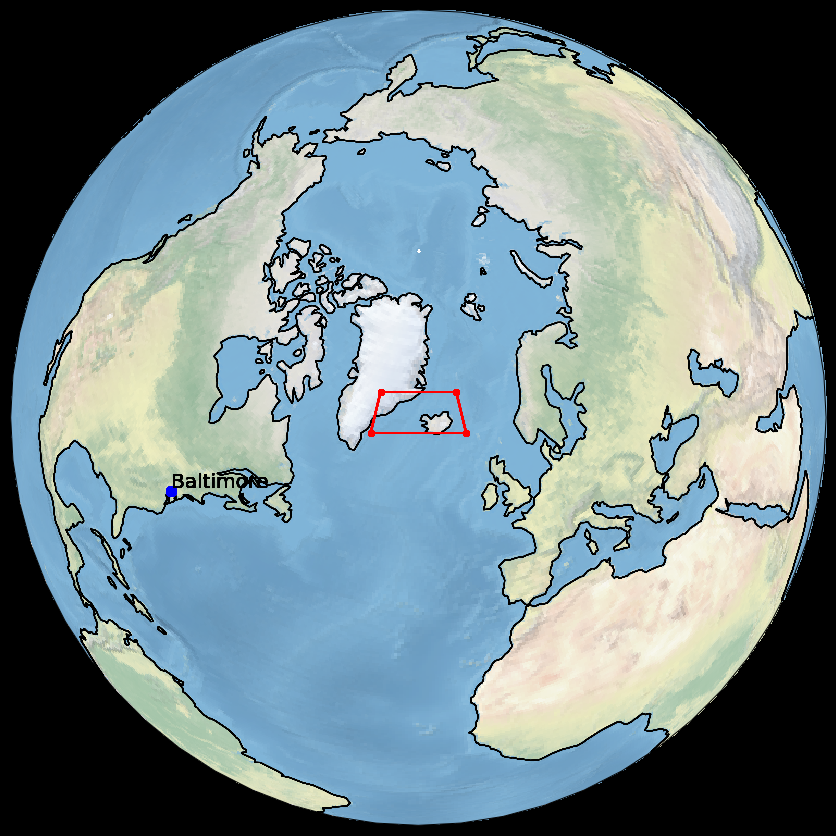

In [7]:
if step1:
    
    # Initialize figure
    fig = plt.figure(facecolor='black')
    if sidebyside:
        fig.set_size_inches(screenX/2/fig.dpi, screenY/fig.dpi)
    else:
        fig.set_size_inches(screenX/fig.dpi, screenY/fig.dpi)

    # Lon/lat vectors
    start_lon, start_lat = -98.35, 0
    steps = step1_frames-step0_frames-trans_frames*2
    lons = np.linspace(start_lon, x_eul.mean(), num = steps) # Strat from center USA
    lats = np.linspace(start_lat, y_eul.mean(), num = steps)
    lons = np.concatenate(([lons[0]]*trans_frames, lons, [lons[-1]]*trans_frames))
    lats = np.concatenate(([lats[0]]*trans_frames, lats, [lats[-1]]*trans_frames))
    
    # Update projection
    print('STEP 1 loop(', step1_frames-1, '):', end=' ')
    for tt in range(step0_frames, step1_frames):
        print(tt, end='-')
        
        # Filename
        zeros = '0'*(padding - len(str(tt)))
        filename = os.path.join(out_path, '{}_{}{}{}'.format(prefix, zeros, tt, ext))

        # Update projection
        projection = ccrs.Orthographic(central_longitude = lons[tt-step0_frames], 
                                       central_latitude  = lats[tt-step0_frames])
        ax = plt.axes(projection=projection)
        
        # Baltimore
        balt_lon, balt_lat = -76.609383, 39.299236
        plt.plot(balt_lon, balt_lat,
                 color='blue', markersize=10, marker='o',
                 transform=ccrs.Geodetic())
        plt.text(balt_lon, balt_lat, 'Baltimore',
                 fontsize = 20,
                 horizontalalignment='left', verticalalignment='bottom',
                 transform=ccrs.Geodetic(), )

        # Plot domain
        plt.plot([x_eul.min(), x_eul.min()], [y_eul.min(), y_eul.max()],
                 color='red', linewidth=2, marker='o', transform=ccrs.Geodetic())
        plt.plot([x_eul.max(), x_eul.max()], [y_eul.min(), y_eul.max()],
                 color='red', linewidth=2, marker='o', transform=ccrs.Geodetic())
        plt.plot([x_eul.min(), x_eul.max()], [y_eul.min(), y_eul.min()],
                 color='red', linewidth=2, marker='o', transform=ccrs.Geodetic())
        plt.plot([x_eul.min(), x_eul.max()], [y_eul.max(), y_eul.max()],
                 color='red', linewidth=2, marker='o', transform=ccrs.Geodetic()) 
        
        # Upload satellite data
        ax.set_global()
        ax.stock_img()
        ax.coastlines()

        # Save
        if sidebyside:

            # Save image
            fig.savefig(out_path+'/Step1'+ext,size=(screenX/2, screenY),facecolor='black')

            # Side-by-Side
            images = map(Image.open, [out_path+'/Step1'+ext, out_path+'/Step1'+ext])
            new_im = Image.new('RGB', (screenX, screenY)) 
            x_offset = 0
            for im in images:
                new_im.paste(im, (x_offset,0))
                x_offset += im.size[0]

            # Save snapshot
            new_im.save(filename,quality=95,size=(screenX, screenY))
            
        else:
            # Save image
            fig.savefig(filename,size=(screenX, screenY),facecolor='black')

# Initialize Figure

In [8]:
if sidebyside:
    fig = mlab.figure(bgcolor=(0,0,0), 
                      fgcolor=(1,1,1), 
                      size=(screenX/2, screenY))
else:
    fig = mlab.figure(bgcolor=(0,0,0), 
                      fgcolor=(1,1,1), 
                      size=(screenX, screenY))

# Add bathymetry
Set surface parameter (e.g., colormap, ...)

In [9]:
surf = mlab.surf(x_eul, y_eul, bathy, colormap   = 'copper',
                                      warp_scale = "auto")

# Rescale 
``warp_scale="auto"`` automatically rescale x, y, and z.  
Thus, particles need to be rescaled.

In [10]:
# Get bathymetry scale and axis origin
scale    = surf.actor.actor.scale
position = surf.actor.actor.position

# Scale particle positions
f_lons_scaled = f_lons * scale[0] + position[0]
f_lats_scaled = f_lats * scale[1] + position[1]
f_deps_scaled = f_deps * scale[2] + position[2]

# Scale domain limits
lon0_scaled = lon0 * scale[0] + position[0]
lon1_scaled = lon1 * scale[0] + position[0]
lat0_scaled = lat0 * scale[1] + position[1] 
lat1_scaled = lat1 * scale[1] + position[1]

# Add particles
Set particle parameters (e.g., colormap, shape, scale, ...)


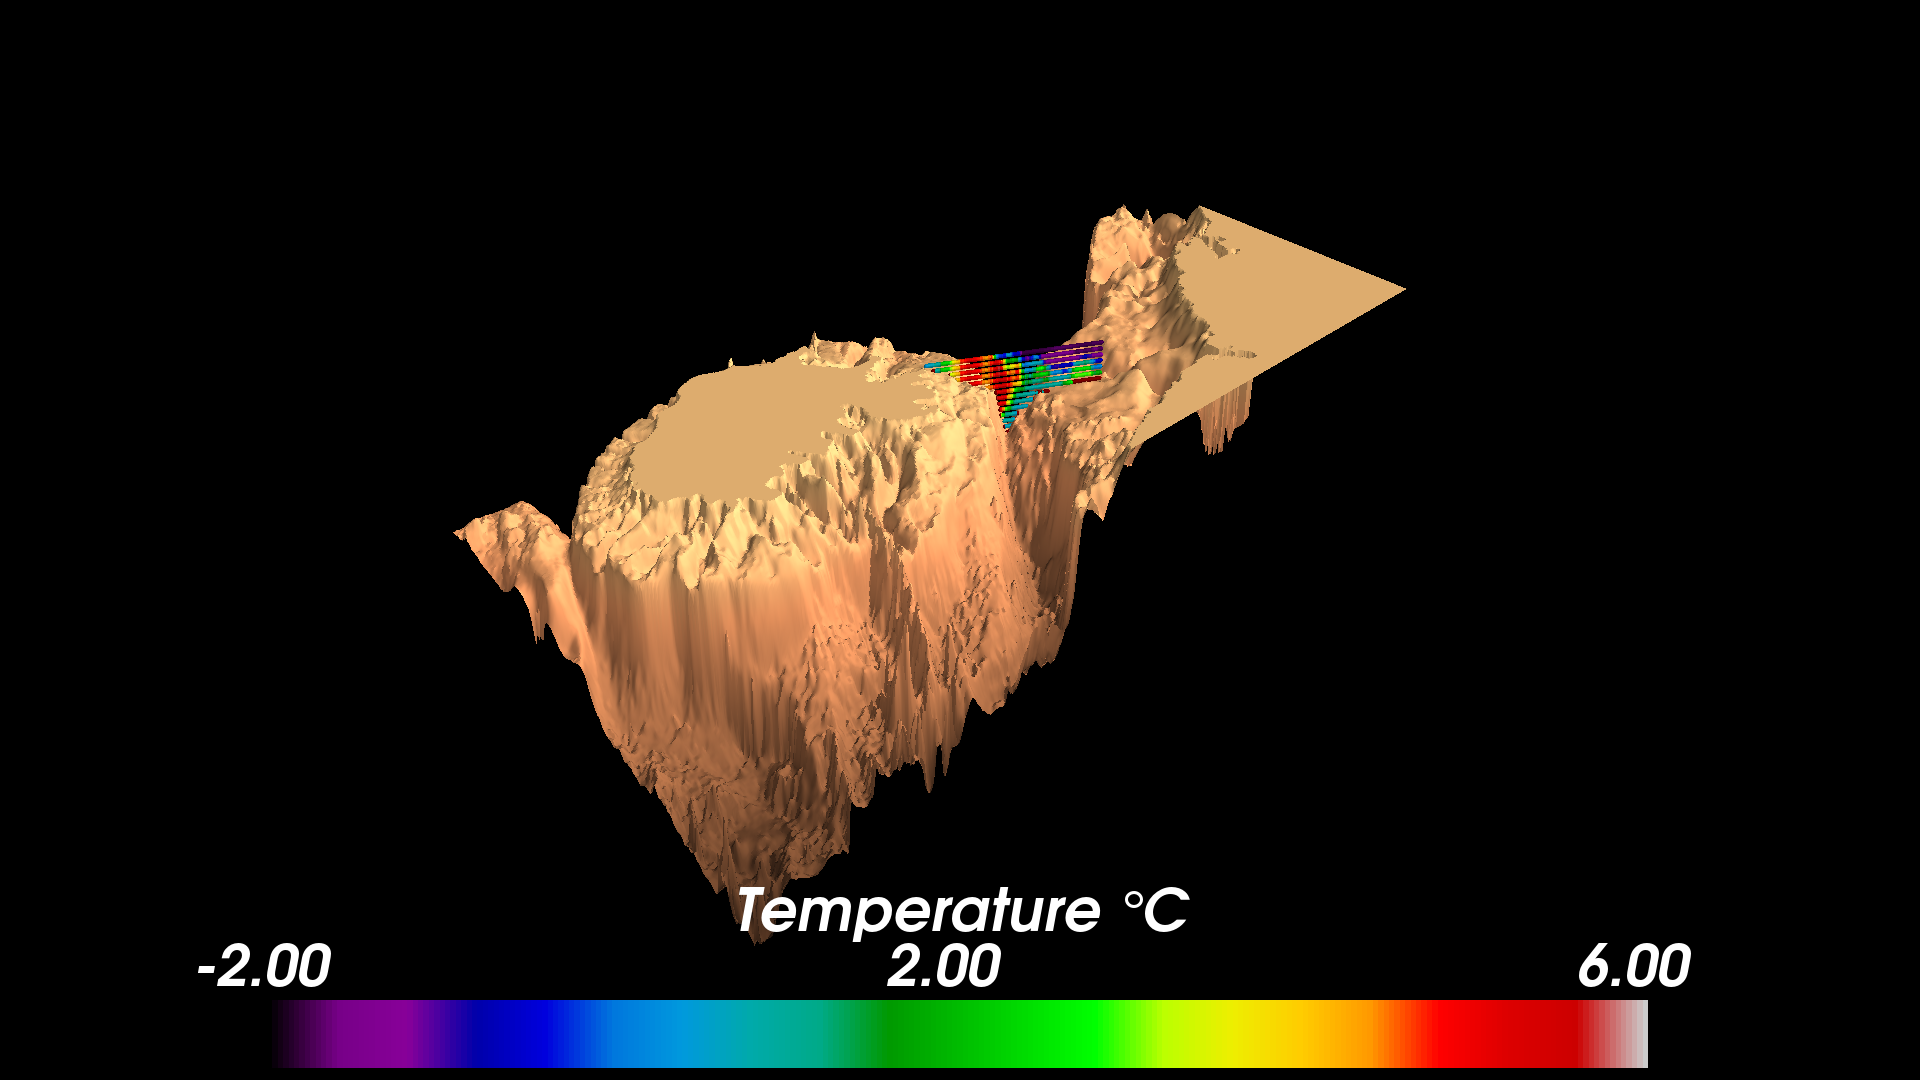

In [11]:
points3d = mlab.points3d(f_lons_scaled[:,0], f_lats_scaled[:,0], f_deps_scaled[:,0], f_TT[:,0],
                         colormap="spectral", 
                         scale_factor=3,
                         opacity=1,
                         mode="sphere",
                         scale_mode="vector",
                         vmin         = np.floor(np.nanmin(f_TT)),
                         vmax         = np.ceil(np.nanmax(f_TT)))
mlab.colorbar(object=points3d,title='Temperature °C',nb_labels=3)

# Step 2: Move camera
Rotate from horizontal plane to a nice view

In [12]:
# Initial camera
fig.scene.z_plus_view()
ini_azimuth, ini_elevation, _, _ = mlab.view()
ini_roll   = mlab.roll()

# Camera vectors
steps = step2_frames - step1_frames - trans_frames*2
azimuthS   = np.linspace(ini_azimuth,   fin_azimuth,   num = steps) 
elevationS = np.linspace(ini_elevation, fin_elevation, num = steps)
rollS      = np.linspace(ini_roll,      fin_roll,      num = steps)
azimuthS   = np.concatenate(([azimuthS[0]]*trans_frames,   azimuthS,   [azimuthS[-1]]*trans_frames))
elevationS = np.concatenate(([elevationS[0]]*trans_frames, elevationS, [elevationS[-1]]*trans_frames))
rollS      = np.concatenate(([rollS[0]]*trans_frames,      rollS,      [rollS[-1]]*trans_frames))

if step2:
    print('STEP 2 loop (', step2_frames-1, '):', end=' ')
    for tt in range(step1_frames, step2_frames):
        print(tt, end='-')
        
        # Filename
        zeros = '0'*(padding - len(str(tt)))
        filename = os.path.join(out_path, '{}_{}{}{}'.format(prefix, zeros, tt, ext))

        # Change view    
        mlab.view(azimuth    = azimuthS[tt-step2_frames], 
                  elevation  = elevationS[tt-step2_frames], 
                  distance   = 'auto',
                  focalpoint = 'auto', 
                  roll       = rollS[tt-step2_frames])

        if sidebyside:
            # Get Distance
            view = mlab.view()
            distance = view[2]

            # Left Image
            mlab.move(right=-distance/(ratioSep*2))
            fig.scene.save(out_path+'/Left'+ext,size=(screenX/2, screenY))
    
            # Right Image
            mlab.move(right=+distance/ratioSep)
            fig.scene.save(out_path+'/Right'+ext,size=(screenX/2, screenY))

            # Reposition
            mlab.move(right=-distance/(ratioSep*2))
            
            # Side-by-Side
            images = map(Image.open, [out_path+'/Left'+ext, out_path+'/Right'+ext])
            new_im = Image.new('RGB', (screenX, screenY)) 
            x_offset = 0
            for im in images:
                new_im.paste(im, (x_offset,0))
                x_offset += im.size[0] 

            # Save snapshot
            new_im.save(filename,quality=95,size=(screenX, screenY))
            
        else:
            # Save snapshot
            fig.scene.save(filename,size=(screenX, screenY))

else:
    # Final snapshot
    mlab.view(azimuth    = azimuthS[-1], 
              elevation  = elevationS[-1], 
              distance   = 'auto',
              focalpoint = 'auto', 
              roll       = rollS[-1])

Creating step 2 snapshots ( 289 ): 110-111-112-113-114-115-116-117-118-119-120-121-122-123-124-125-126-127-128-129-130-131-132-133-134-135-136-137-138-139-140-141-142-143-144-145-146-147-148-149-150-151-152-153-154-155-156-157-158-159-160-161-162-163-164-165-166-167-168-169-170-171-172-173-174-175-176-177-178-179-180-181-182-183-184-185-186-187-188-189-190-191-192-193-194-195-196-197-198-199-200-201-202-203-204-205-206-207-208-209-210-211-212-213-214-215-216-217-218-219-220-221-222-223-224-225-226-227-228-229-230-231-232-233-234-235-236-237-238-239-240-241-242-243-244-245-246-247-248-249-250-251-252-253-254-255-256-257-258-259-260-261-262-263-264-265-266-267-268-269-270-271-272-273-274-275-276-277-278-279-280-281-282-283-284-285-286-287-288-289-

# Step 3: Zoom in
Zoom into the Strait

In [13]:
# Initial distance
_, _, ini_distance, _ = mlab.view()

# Move vectors
steps = step3_frames-step2_frames- trans_frames*2
forward_step = [forw_move /steps]*steps
right_step   = [right_move/steps]*steps
up_step      = [up_move   /steps]*steps
forward_step = np.concatenate(([0]*trans_frames, forward_step, [0]*trans_frames))
right_step   = np.concatenate(([0]*trans_frames, right_step,   [0]*trans_frames))
up_step      = np.concatenate(([0]*trans_frames, up_step,      [0]*trans_frames))

if step3:
    print('STEP 3 loop (', step3_frames-1, '):', end=' ')
    for tt in range(step2_frames, step3_frames):
        print(tt, end='-')
        
        # Filename
        zeros = '0'*(padding - len(str(tt)))
        filename = os.path.join(out_path, '{}_{}{}{}'.format(prefix, zeros, tt, ext))

        # Move camera
        mlab.move(forward = forward_step[tt-step2_frames],
                  right   = right_step[tt-step2_frames],
                  up      = up_step[tt-step2_frames])

        if sidebyside:
            # Get Distance
            view = mlab.view()
            distance = view[2]

            # Left Image
            mlab.move(right=-distance/(ratioSep*2))
            fig.scene.save(out_path+'/Left'+ext,size=(screenX/2, screenY))

            # Right Image
            mlab.move(right=+distance/ratioSep)
            fig.scene.save(out_path+'/Right'+ext,size=(screenX/2, screenY))

            # Reposition
            mlab.move(right=-distance/(ratioSep*2))

            # Side-by-Side
            images = map(Image.open, [out_path+'/Left'+ext, out_path+'/Right'+ext])
            new_im = Image.new('RGB', (screenX, screenY)) 
            x_offset = 0
            for im in images:
                new_im.paste(im, (x_offset,0))
                x_offset += im.size[0] 

            # Save snapshot
            new_im.save(filename,quality=95,size=(screenX, screenY))
        
        else:
            # Save snapshot
            fig.scene.save(filename,size=(screenX, screenY))

else:
    # Final snapshot    
    mlab.move(forward=forw_move,up=up_move, right=right_move)

Creating step 3 snapshots ( 469 ): 290-291-292-293-294-295-296-297-298-299-300-301-302-303-304-305-306-307-308-309-310-311-312-313-314-315-316-317-318-319-320-321-322-323-324-325-326-327-328-329-330-331-332-333-334-335-336-337-338-339-340-341-342-343-344-345-346-347-348-349-350-351-352-353-354-355-356-357-358-359-360-361-362-363-364-365-366-367-368-369-370-371-372-373-374-375-376-377-378-379-380-381-382-383-384-385-386-387-388-389-390-391-392-393-394-395-396-397-398-399-400-401-402-403-404-405-406-407-408-409-410-411-412-413-414-415-416-417-418-419-420-421-422-423-424-425-426-427-428-429-430-431-432-433-434-435-436-437-438-439-440-441-442-443-444-445-446-447-448-449-450-451-452-453-454-455-456-457-458-459-460-461-462-463-464-465-466-467-468-469-

# Step 4: Release particles and zoom-out
Release particle and zoom back to nice initial view

In [14]:
if step4:
    print('STEP 4 loop (', step4_frames-1, '):', end=' ')
    for tt in range(step3_frames, step4_frames):
        print(tt, end='-')

        # Filename
        zeros = '0'*(padding - len(str(tt)))
        filename = os.path.join(out_path, '{}_{}{}{}'.format(prefix, zeros, tt, ext))

        # Extract values
        tt_part = tt-step3_frames
        x_lag = f_lons_scaled[:,tt_part]
        y_lag = f_lats_scaled[:,tt_part]
        z_lag = f_deps_scaled[:,tt_part]
        T_lag = f_TT[:,tt_part]
        S_lag = f_SS[:,tt_part]

        # Mask domain
        mask_x = np.logical_and(x_lag>lon0_scaled,x_lag<lon1_scaled)
        mask_y = np.logical_and(y_lag>lat0_scaled,y_lag<lat1_scaled)
        mask   = np.logical_and(mask_x,mask_y)

        # Apply mask
        x_lag = x_lag[mask]
        y_lag = y_lag[mask]
        z_lag = z_lag[mask]
        T_lag = T_lag[mask]
        S_lag = S_lag[mask]

        # Update particles
        points3d.mlab_source.reset(x=x_lag, y=y_lag, z=z_lag, scalars=T_lag)

        # Move
        steps = step4_frames-step3_frames
        mlab.move(forward = -forw_move/steps,
                  right   = -right_move/steps,
                  up      = -up_move/steps)

        if sidebyside:
            # Get Distance
            view = mlab.view()
            distance = view[2]

            # Left Image
            mlab.move(right=-distance/(ratioSep*2))
            fig.scene.save(out_path+'/Left'+ext,size=(screenX/2, screenY))

            # Right Image
            mlab.move(right=+distance/ratioSep)
            fig.scene.save(out_path+'/Right'+ext,size=(screenX/2, screenY))

            # Reposition
            mlab.move(right=-distance/(ratioSep*2))

            # Side-by-Side
            images = map(Image.open, [out_path+'/Left'+ext, out_path+'/Right'+ext])
            new_im = Image.new('RGB', (screenX, screenY)) 
            x_offset = 0
            for im in images:
                new_im.paste(im, (x_offset,0))
                x_offset += im.size[0] 

            # Save snapshot
            new_im.save(filename,quality=95,size=(screenX, screenY))
            
        else:
            # Save snapshot
            fig.scene.save(filename,size=(screenX, screenY))

else:
    # Final snapshot    
    mlab.move(forward = -forw_move,
              up      = -up_move, 
              right   = -right_move)

Creating step 4 snapshots ( 710 ): 470-471-472-

/home/mattia/anaconda3/envs/3D/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in greater
/home/mattia/anaconda3/envs/3D/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in less
/home/mattia/anaconda3/envs/3D/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in greater
/home/mattia/anaconda3/envs/3D/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in less


473-474-475-476-477-478-479-480-481-482-483-484-485-486-487-488-489-490-491-492-493-494-495-496-497-498-499-500-501-502-503-504-505-506-507-508-509-510-511-512-513-514-515-516-517-518-519-520-521-522-523-524-525-526-527-528-529-530-531-532-533-534-535-536-537-538-539-540-541-542-543-544-545-546-547-548-549-550-551-552-553-554-555-556-557-558-559-560-561-562-563-564-565-566-567-568-569-570-571-572-573-574-575-576-577-578-579-580-581-582-583-584-585-586-587-588-589-590-591-592-593-594-595-596-597-598-599-600-601-602-603-604-605-606-607-608-609-610-611-612-613-614-615-616-617-618-619-620-621-622-623-624-625-626-627-628-629-630-631-632-633-634-635-636-637-638-639-640-641-642-643-644-645-646-647-648-649-650-651-652-653-654-655-656-657-658-659-660-661-662-663-664-665-666-667-668-669-670-671-672-673-674-675-676-677-678-679-680-681-682-683-684-685-686-687-688-689-690-691-692-693-694-695-696-697-698-699-700-701-702-703-704-705-706-707-708-709-710-

# Step 5: Zoom in again

In [15]:
if step5:
    
    # Move vectors
    steps = step5_frames-step4_frames- trans_frames*2
    forward_step = [forw_move  / steps]*steps
    right_step   = [right_move / steps]*steps
    up_step      = [up_move    / steps]*steps
    forward_step = np.concatenate(([0]*trans_frames, forward_step, [0]*trans_frames))
    right_step   = np.concatenate(([0]*trans_frames, right_step,   [0]*trans_frames))
    up_step      = np.concatenate(([0]*trans_frames, up_step,      [0]*trans_frames))

    # Update view
    print('STEP 5 loop (', step5_frames-1, '):', end=' ')
    for tt in range(step4_frames, step5_frames):
        print(tt, end='-')
        
        # Filename
        zeros = '0'*(padding - len(str(tt)))
        filename = os.path.join(out_path, '{}_{}{}{}'.format(prefix, zeros, tt, ext))

        # Move
        mlab.move(forward = forward_step[tt-step4_frames],
                  right   = right_step[tt-step4_frames],
                  up      = up_step[tt-step4_frames])

        if sidebyside:
            # Get Distance
            view = mlab.view()
            distance = view[2]

            # Left Image
            mlab.move(right=-distance/(ratioSep*2))
            fig.scene.save(out_path+'/Left'+ext,size=(screenX/2, screenY))

            # Right Image
            mlab.move(right=+distance/ratioSep)
            fig.scene.save(out_path+'/Right'+ext,size=(screenX/2, screenY))

            # Reposition
            mlab.move(right=-distance/(ratioSep*2))

            # Side-by-Side
            images = map(Image.open, [out_path+'/Left'+ext, out_path+'/Right'+ext])
            new_im = Image.new('RGB', (screenX, screenY)) 
            x_offset = 0
            for im in images:
                new_im.paste(im, (x_offset,0))
                x_offset += im.size[0] 

            # Save snapshot
            new_im.save(filename,quality=95,size=(screenX, screenY))
        
        else:
            # Save snapshot
            fig.scene.save(filename,size=(screenX, screenY))

else:
    # Final snapshot    
    mlab.move(forward = forw_move,
              up      = up_move, 
              right   = right_move)

Creating step 5 snapshots ( 890 ): 711-712-713-714-715-716-717-718-719-720-721-722-723-724-725-726-727-728-729-730-731-732-733-734-735-736-737-738-739-740-741-742-743-744-745-746-747-748-749-750-751-752-753-754-755-756-757-758-759-760-761-762-763-764-765-766-767-768-769-770-771-772-773-774-775-776-777-778-779-780-781-782-783-784-785-786-787-788-789-790-791-792-793-794-795-796-797-798-799-800-801-802-803-804-805-806-807-808-809-810-811-812-813-814-815-816-817-818-819-820-821-822-823-824-825-826-827-828-829-830-831-832-833-834-835-836-837-838-839-840-841-842-843-844-845-846-847-848-849-850-851-852-853-854-855-856-857-858-859-860-861-862-863-864-865-866-867-868-869-870-871-872-873-874-875-876-877-878-879-880-881-882-883-884-885-886-887-888-889-890-

# Generate movie

In [16]:
if create_movie:
    # Create movie using ffmpeg
    ffmpeg_fname = os.path.join(out_path, '{}_%0{}d{}'.format(prefix, padding, ext))
    cmd = 'ffmpeg -f image2 -r {} -i {} -s hd1080 -vcodec libx264 -crf 18 -preset slow -y {}{}'.format(fps,
                                                                        ffmpeg_fname,
                                                                        prefix,
                                                                        ext_mov)
    print('\n',cmd)
    subprocess.check_output(['bash','-c', cmd])

    # !! DANGER !! 
    # Remove temp image files with extension
    # [os.remove(f) for f in os.listdir(out_path) if f.endswith(ext)]


 ffmpeg -f image2 -r 10 -i /home/mattia/Desktop/3D/snapshots3D/Dive_Denmark_Strait_3D_%03d.jpg -s hd1080 -vcodec libx264 -crf 18 -preset slow -y Dive_Denmark_Strait_3D.mp4
